In [1]:
using AutoRisk
using Distributions
using HDF5
using PGFPlots

In [74]:
function build_basic_scenario(seed::Int; 
        σ_lon::Float64 = 0., 
        lo_Δs::Float64 = 10., 
        hi_Δs::Float64 = 20.,
        ego_v::Float64 = 5.,
        oth_v::Float64 = 0.)
    srand(seed)
    # add three vehicles and specifically check neighbor features
    context = IntegratedContinuous(.1, 1)
    num_veh = 2
    roadway = gen_straight_roadway(1, 50.)
    scene = Scene(num_veh)
    models = Dict{Int, DriverModel}()

    # 1: first vehicle, moving the fastest
    mlon = StaticLongitudinalDriver(0.)
    mlon.σ = σ_lon
    models[1] = Tim2DDriver(context, mlon = mlon)
    road_idx = RoadIndex(proj(VecSE2(0.0, 0.0, 0.0), roadway))
    base_speed = ego_v
    veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
    veh_def = VehicleDef(1, AgentClass.CAR, 5., 2.)
    push!(scene, Vehicle(veh_state, veh_def))

    # 2: second vehicle, in front
    mlon = StaticLongitudinalDriver(0.)
    models[2] = Tim2DDriver(context, mlon = mlon)
    base_speed = oth_v
    Δs = rand(Uniform(lo_Δs, hi_Δs))
    veh_state = VehicleState(Frenet(road_idx, roadway), roadway, base_speed)
    veh_state = move_along(veh_state, roadway, Δs)
    veh_def = VehicleDef(2, AgentClass.CAR, 5., 2.)
    push!(scene, Vehicle(veh_state, veh_def))
    return scene, models, roadway
end

build_basic_scenario (generic function with 1 method)

In [75]:
# build evaluator 
function build_evaluator(num_runs::Int = 10)
    context = IntegratedContinuous(.1, 1)
    num_veh = 2
    prime_time = .1
    sampling_time = 10.
    sampling_period = .1
    veh_idx_can_change = false
    num_scenes = Int(ceil((prime_time + sampling_time) / sampling_period)) + 1

    subexts = Vector{AbstractFeatureExtractor}([CarLidarFeatureExtractor()])
    ext = MultiFeatureExtractor(subexts)
    # ext = MultiFeatureExtractor()
    num_features = length(ext)
    num_targets = 5
    rec = SceneRecord(num_scenes, .1, num_veh)
    features = Array{Float64}(num_features, 1, num_veh)
    targets = Array{Float64}(num_targets, num_veh)
    agg_targets = Array{Float64}(num_targets, num_veh)

    rng = MersenneTwister(1)
    eval = MonteCarloEvaluator(ext, num_runs, context, prime_time, sampling_time,
        veh_idx_can_change, rec, features, targets, agg_targets, rng)
    return eval
end

build_evaluator (generic function with 2 methods)

In [76]:
function visualize_scenario(rec::SceneRecord)
    @manipulate for veh_id in collect(1:length(rec.scenes[1])),
                zoom in [10.],
                i in 1:(rec.nscenes)
        idx = -(rec.nscenes - i)
        stats = [CarFollowingStatsOverlay(veh_id, 2), NeighborsOverlay(veh_id, textparams = TextParams(x = 600, y_start=300))]
        cam = CarFollowCamera(veh_id, zoom)
        render(get_scene(rec, idx), roadway, stats, cam = cam)
    end
end

visualize_scenario (generic function with 1 method)

In [77]:
function build_dataset(scenario_gen, eval::Evaluator, num_scenarios::Int, kwargs::Dict=Dict())
    num_features, num_timesteps, num_veh_per_scenario = size(eval.features)
    num_targets, num_veh_per_scenario = size(eval.targets)
    features = zeros(num_features, num_timesteps, num_veh_per_scenario * num_scenarios)
    targets = zeros(num_targets, num_veh_per_scenario * num_scenarios)
    for sidx in 1:num_scenarios
        scene, models, roadway = scenario_gen(sidx; kwargs...)
        evaluate!(eval, scene, models, roadway, sidx)
        s = (sidx - 1) * num_veh_per_scenario
        e = s + num_veh_per_scenario
        features[:, :, (s+1):e] = get_features(eval)
        targets[:, (s+1):e] = get_targets(eval)
    end
    return features, targets
end

build_dataset (generic function with 2 methods)

In [78]:
function save_dataset(filepath, features, targets)
    h5write(filepath, "risk/features", features)
    h5write(filepath, "risk/targets", targets)
end

save_dataset (generic function with 1 method)

Interact.Options{:ToggleButtons,Int64}(Signal{Int64}(1, nactions=1),"veh_id",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2),Dict(2=>"2",1=>"1")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Float64}(Signal{Float64}(10.0, nactions=1),"zoom",10.0,"10.0",Interact.OptionDict(DataStructures.OrderedDict("10.0"=>10.0),Dict(10.0=>"10.0")),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(51, nactions=1),"i",51,"51",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

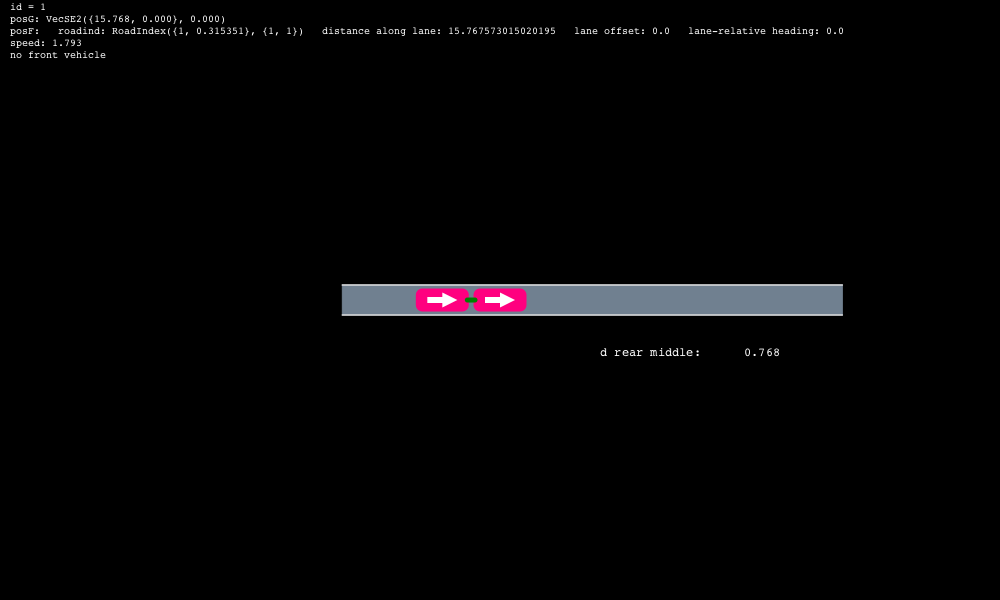

In [79]:
scene, models, roadway = build_basic_scenario(1, σ_lon=2., hi_Δs=10., lo_Δs=9.999)
eval = build_evaluator(2)
evaluate!(eval, scene, models, roadway, 1)
visualize_scenario(eval.rec)

In [80]:
# plan
# everything happens at time t where 1. < t <= 2.
# across all the different scenes
# where prediction is increasingly complex for the different scenes being generated

In [ ]:
# simplest possible scenario, static vehicles, deterministic acceleration
# kwargs = Dict() 
num_runs = 3
kwargs = Dict(:σ_lon => 2., :hi_Δs=>10., :lo_Δs=>5., :ego_v=>0., :oth_v=>0.)
eval_runs = [Int(ceil(v)) for v in linspace(1, 300, num_runs)]
features_list = []
targets_list = []
for i in 1:num_runs
    eval = build_evaluator(eval_runs[i])
    features, targets = build_dataset(build_basic_scenario, eval, 50, kwargs);
    push!(features_list, features)
    push!(targets_list, targets)
end

In [82]:
features = features_list[1]
targets = targets_list[1]
rm("../../data/datasets/debug/static_nondeterministic.h5")
save_dataset("../../data/datasets/debug/static_nondeterministic.h5", features[:,:,1:2:end], targets[:,1:2:end])


In [83]:
println(sum(targets[3,1:2:end]) / length(targets[3,1:2:end]))
println(sum(targets[2,:]))

1.0
200.0


In [ ]:
g = GroupPlot(3, 2, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
for i in 1:length(features_list)
    features = features_list[i]
    targets = targets_list[i]
    a = Axis(Plots.Scatter(features[10,1,1:2:end], targets[3, 1:2:end]), title=string(eval_runs[i]))
    push!(g,a)
end
g